# Laboratorio 5
## Data Science
#### Sección 40
Javier Alejandro Ovalle Chiquín, 22103  
José Ángel Morales Farfán, 22689  
Ricardo Josué Morales Contreras, 22289

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [13]:
# ==== Cargar CSV ====
df = pd.read_csv("tweets_texto_normalizados.csv")  
dfor = pd.read_csv("tweets.csv")

#### Analisis exploratorio

Shape del dataset: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason this earthquake allah forgive,1
1,4,NaN,NaN,forest fire near ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place being notified o...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,just sent this photo from ruby alaska smoke fr...,1



Tipos de datos y nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7605 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
id             0
keyword       61
location    2533
text           8
target         0
dtype: int64
----------------------------

Duplicados por id: 0
Duplicados por texto: 869
----------------------------


Balance de clases (target):
target
0    4342
1    3271
Name: count, dtype: int64
----------------------------


Estadísticas de longitud:
count    7613.000000
mean       60.688428
std        25.345176
min         3.000000
25%        42.000000
50%        61.000000
75%        80.000000
max       134.000000
Name: text_len, dtype: float64
---

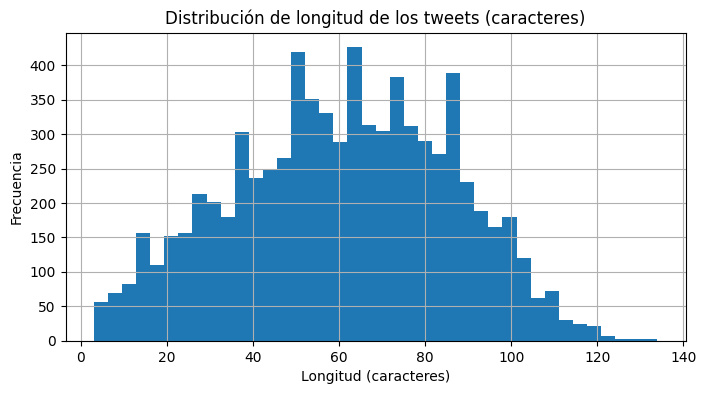

In [14]:
# ==== Vista rápida ====
print("Shape del dataset:", df.shape)
display(df.head())

# ==== Info de columnas ====
print("\nTipos de datos y nulos:")
print(df.info())
print(df.isna().sum())
print("----------------------------\n")

# ==== Revisar duplicados ====
dup_id = df["id"].duplicated().sum()
dup_text = df["text"].duplicated().sum()
print(f"Duplicados por id: {dup_id}")
print(f"Duplicados por texto: {dup_text}")
print("----------------------------\n")

# ==== Balance de clases ====
print("\nBalance de clases (target):")
print(df["target"].value_counts())
print("----------------------------\n")

# ==== Estadísticas de longitud de texto ====
df["text_len"] = df["text"].astype(str).str.len()
print("\nEstadísticas de longitud:")
print(df["text_len"].describe())
print("----------------------------\n")

# Histograma de longitudes
plt.figure(figsize=(8,4))
df["text_len"].hist(bins=40)
plt.title("Distribución de longitud de los tweets (caracteres)")
plt.xlabel("Longitud (caracteres)")
plt.ylabel("Frecuencia")
plt.show()

#### Sección 3

In [15]:
#import pandas as pd
#import re
#import html
#import numpy as np

# === Función de limpieza ===
#def clean_text_for_classification(text: str) -> str:
#    text = str(text)
#    text = html.unescape(text)       # decodificar entidades HTML (&amp;)
#    text = text.lower()
#    text = re.sub(r"<.*?>", " ", text)                  # eliminar HTML
#    text = re.sub(r"http\S+|www\.\S+", " ", text)       # eliminar URLs
#    text = re.sub(r"@\w+", " ", text)                   # eliminar menciones
#    text = text.replace("#", " ")                       # quitar '#' pero dejar palabra
#    text = re.sub(r"[^\x00-\x7F]+", " ", text)          # quitar no-ASCII
#    # preservar "911" explícitamente
#    text = re.sub(r"\b911\b", " nineoneone_token ", text)
#    text = re.sub(r"\d+", " ", text)                    # eliminar números
#    text = re.sub(r"nineoneone_token", " 911 ", text)
#    text = re.sub(r"[^\w\s]", " ", text)                # quitar puntuación
#    text = re.sub(r"\s+", " ", text).strip()            # normalizar espacios
#    return text

# === 3. Crear la columna text_clean ===
#df["text_clean"] = df["text"].astype(str).apply(clean_text_for_classification)


In [16]:
df['text_original'] = dfor['text']

In [17]:
print(df.columns)

Index(['id', 'keyword', 'location', 'text', 'target', 'text_len',
       'text_original'],
      dtype='object')


Ahora se va a verificar las keywords, además de crear una columna secundaría de keywords para tener un argumento más robusto a la hora de verificar si el comentario es relacionado con un desastre o no 

In [18]:
# === 4. Preparar lista de keywords ===
keyword_list = df["keyword"].dropna().unique().tolist()
keyword_list = [k.lower().replace("%20", " ") for k in keyword_list]

extra_keywords = ["evacuation", "rescue", "explosion", "emergency", "burning"]
keywords = sorted(set(keyword_list + extra_keywords))

# === 5. Función para buscar keywords ===
def find_keywords(text, keyword_set):
    found = []
    for kw in keyword_set:
        if re.search(r"\b" + re.escape(kw) + r"\b", text):
            found.append(kw)
    return found

# === 6. Crear columnas de keywords ===
df["keywords_found"] = df["text"].apply(lambda x: find_keywords(str(x), keywords))
df["keyword_primary"] = df["keywords_found"].apply(lambda x: x[0] if len(x) > 0 else np.nan)
df["keyword_secondary"] = df["keywords_found"].apply(lambda x: x[1] if len(x) > 1 else np.nan)

# === 7. Ver resultado ===
print(df[["text", "keywords_found", "keyword_primary", "keyword_secondary"]].head(10))


                                                text  \
0         deeds reason this earthquake allah forgive   
1                 forest fire near ronge sask canada   
2  residents asked shelter place being notified o...   
3  people receive wildfires evacuation orders cal...   
4  just sent this photo from ruby alaska smoke fr...   
5  rockyfire update california closed both direct...   
6  flood disaster heavy rain causes flash floodin...   
7                                    hill fire woods   
8  there emergency evacuation happening building ...   
9                    afraid that tornado coming area   

                keywords_found keyword_primary keyword_secondary  
0                 [earthquake]      earthquake               NaN  
1          [fire, forest fire]            fire       forest fire  
2                 [evacuation]      evacuation               NaN  
3                 [evacuation]      evacuation               NaN  
4                      [smoke]           smoke  

Ahora para el modelo preeliminar de selección: 

Para el modelo preliminar de clasificación se propone utilizar un clasificador lineal, específicamente una Regresión Logística o un SVM lineal. Este enfoque resulta adecuado debido a que los mensajes en Twitter son cortos y los n-gramas permiten capturar de manera efectiva términos clave como “fire”, “earthquake” o “evacuation order”, los cuales son relevantes para identificar desastres. Aesta propuesta ofrece una solución práctica y efectiva para establecer una línea base sólida sobre la cual se pueden comparar modelos más avanzados en etapas posteriores del proyecto.

#### Sección 4

,token,freq
0,news,137
1,disaster,121
2,california,115
3,suicide,112
4,police,109
5,people,105
6,killed,95
7,hiroshima,92
8,storm,89
9,fires,85


,token,freq
0,body,116
1,video,96
2,people,94
3,love,91
4,know,86
5,time,84
6,emergency,81
7,going,76
8,want,67
9,good,67


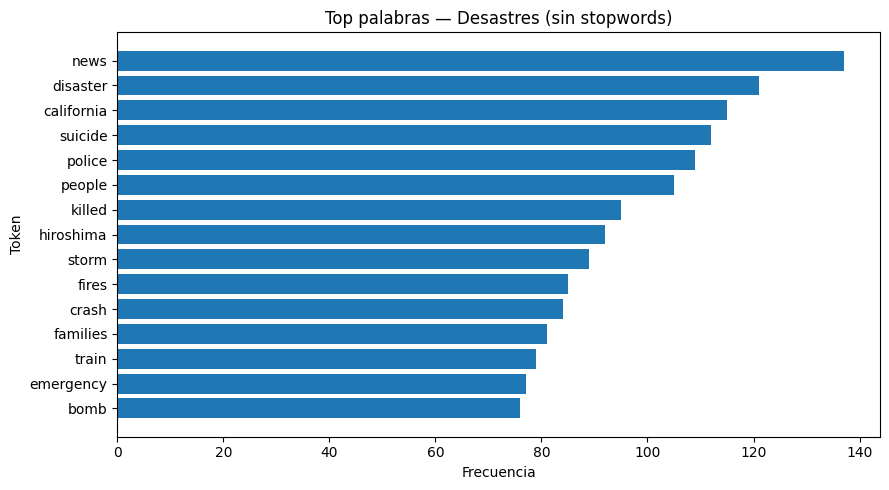

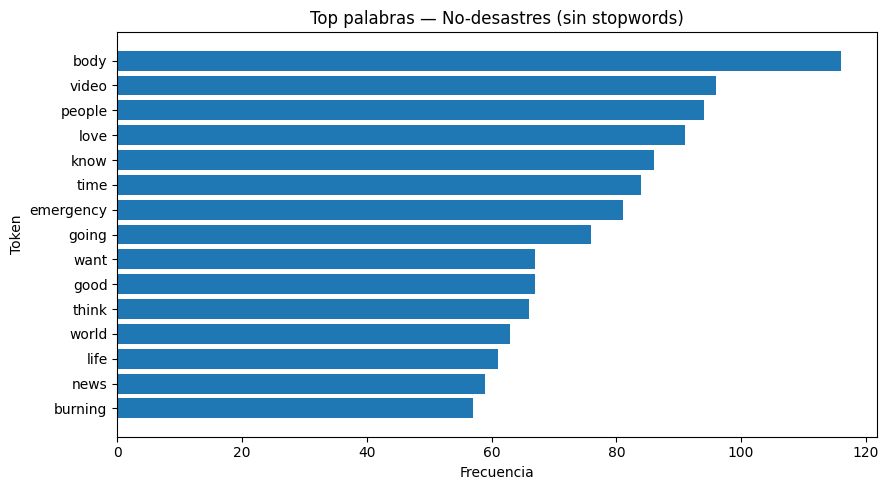

In [23]:

# --- Stopwords (inglés + dominio) ---
custom_stop = {
    # conectores/comunes
    "im","ive","u","ur","rt","via","amp","us","one","two","get","got","still","today","yesterday",
    # pronombres/auxiliares muy poco informativos
    "this","that","these","those","with","from","have","has","had","been","being","was","were","will","would",
    "they","their","there","here","your","you","we","our","just","like","more","when","what","over","into",
}
STOP = set(ENGLISH_STOP_WORDS) | custom_stop

# Tokenización segura
df["text"] = df["text"].fillna("").astype(str)
df["tokens"] = df["text"].str.split()
df["tokens"] = df["tokens"].apply(lambda toks: [t for t in toks if t and t not in STOP])

# Separar tokens por clase
tokens_disaster = [t for row in df.loc[df["target"]==1, "tokens"].dropna() for t in row]
tokens_nondisaster = [t for row in df.loc[df["target"]==0, "tokens"].dropna() for t in row]

# Top-N
TOP_N = 25
freq_disaster = pd.DataFrame(Counter(tokens_disaster).most_common(TOP_N), columns=["token","freq"])
freq_nondisaster = pd.DataFrame(Counter(tokens_nondisaster).most_common(TOP_N), columns=["token","freq"])

display(freq_disaster)
display(freq_nondisaster)

# Gráficos
def plot_top_tokens(df_freq, title, top=15):
    sub = df_freq.head(top)
    plt.figure(figsize=(9,5))
    plt.barh(sub["token"][::-1], sub["freq"][::-1])
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("Token")
    plt.tight_layout()
    plt.show()

plot_top_tokens(freq_disaster, "Top palabras — Desastres (sin stopwords)", top=15)
plot_top_tokens(freq_nondisaster, "Top palabras — No-desastres (sin stopwords)", top=15)



In [25]:
from sklearn.feature_extraction.text import CountVectorizer

STOP_LIST = list(STOP)  # usar las mismas stopwords

def top_ngrams(texts, ngram_range=(1,1), top_k=20, min_df=2):
    texts = [x for x in texts if isinstance(x, str) and x.strip()]
    if not texts:
        return pd.DataFrame(columns=["ngram","freq"])
    vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df, stop_words=STOP_LIST)
    X = vec.fit_transform(texts)
    counts = X.sum(axis=0).A1
    vocab = vec.get_feature_names_out()
    freq = pd.DataFrame({"ngram": vocab, "freq": counts})
    return freq.sort_values("freq", ascending=False).head(top_k).reset_index(drop=True)

texts_all = df["text"].tolist()
texts_d   = df.loc[df["target"]==1, "text"].tolist()
texts_nd  = df.loc[df["target"]==0, "text"].tolist()

uni_global = top_ngrams(texts_all, (1,1), 20)
bi_global  = top_ngrams(texts_all, (2,2), 20)
tri_global = top_ngrams(texts_all, (3,3), 20)

print("Top 20 unigrams (global)"); display(uni_global)
print("Top 20 bigrams (global)");  display(bi_global)
print("Top 20 trigrams (global)"); display(tri_global)

bi_d  = top_ngrams(texts_d, (2,2), 20)
bi_nd = top_ngrams(texts_nd, (2,2), 20)

print("Top 20 bigrams — Desastres");     display(bi_d)
print("Top 20 bigrams — No-desastres");  display(bi_nd)


Top 20 unigrams (global)


,ngram,freq
0,people,199
1,news,196
2,video,165
3,emergency,158
4,disaster,158
5,police,143
6,body,131
7,burning,121
8,storm,121
9,california,121


Top 20 bigrams (global)


,ngram,freq
0,burning buildings,60
1,suicide bomber,59
2,liked video,41
3,northern california,41
4,cross body,40
5,suicide bombing,36
6,california wildfire,34
7,natural disaster,32
8,mass murder,32
9,mass murderer,31


Top 20 trigrams (global)


,ngram,freq
0,suicide bomber detonated,30
1,northern california wildfire,29
2,16yr suicide bomber,28
3,bomber detonated bomb,28
4,homes razed northern,28
5,latest homes razed,28
6,razed northern california,27
7,affected fatal outbreak,26
8,families affected fatal,26
9,wreckage conclusively confirmed,25


Top 20 bigrams — Desastres


,ngram,freq
0,suicide bomber,59
1,northern california,41
2,burning buildings,37
3,suicide bombing,35
4,california wildfire,34
5,bomber detonated,30
6,confirmed mh370,29
7,homes razed,29
8,latest homes,28
9,detonated bomb,28


Top 20 bigrams — No-desastres


,ngram,freq
0,cross body,39
1,liked video,34
2,body bagging,24
3,burning buildings,23
4,body bags,23
5,reddit quarantine,21
6,quarantine offensive,21
7,offensive content,20
8,content policy,20
9,loud bang,19


Al analizar las frecuencias de palabras separando los tweets por clase, se observa una clara diferencia en el vocabulario.

En los tweets de desastres (target=1) destacan términos directamente relacionados con emergencias: news, disaster, california, suicide, police, people, killed, hiroshima, storm, fires, crash, families, train, emergency, bomb. Estas palabras reflejan sucesos como incendios, atentados, tormentas, accidentes y víctimas, lo que confirma que son útiles para identificar mensajes vinculados con eventos catastróficos.

En contraste, los tweets de no-desastres (target=0) muestran un léxico cotidiano y genérico: body, video, people, love, know, time, going, want, good, world, life. Aunque aparecen algunos términos similares (ej. emergency, news), su contexto es distinto y no necesariamente implica un desastre.

El análisis de n-gramas refuerza estas diferencias. En los bigramas de desastres aparecen combinaciones clave como suicide bomber, northern california, california wildfire, burning buildings, bomber detonated, que aportan contexto más específico que un unigram aislado. En cambio, en los bigramas de no-desastres predominan frases poco relacionadas con emergencias, como cross body, liked video, content policy. Los trigramas, aunque menos frecuentes, capturan narrativas completas de desastres, por ejemplo suicide bomber detonated o northern california wildfire.

#### Sección 5